# Yorkeys Knob

This demonstration follows closely one of the ones shown in our [preprint](https://www.biorxiv.org/content/10.1101/2023.06.26.546301v1). We will begin by loading all the required libraries and packages:

In [1]:
from os import path
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import MGSurvE as srv
import warnings
warnings.filterwarnings("ignore")

## Landscape

Let's get some constants set for our experiments. The number of traps will be controlled by `TRPS_NUM`, whith experiment id `ID` being just a label for the output files, and the run id `RID` being used for iterations of the stochastic optimization process. All of our files will be exported to the `sims_out` folder on the root of the current directory.

In [2]:
TRPS_NUM = 16
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('YKN', 0)
# Output folder ---------------------------------------------------------------
OUT_PTH = './out/'
srv.makeFolder(OUT_PTH)

To get started with our landscape, we need to import our latitude/longitude pairs for the households in it. Once we have loaded them into a pandas dataframe (`YK_LL`), we set the type `t` for all of the traps as `0`, as we will be assuming that each household contains all the required resources for mosquito survival. Finally, we will define a bounding box (`YK_BBOX`) for plotting purposes:

In [3]:
LND_PTH = '../../data/{}_LatLon.csv'.format(ID)
YK_LL = pd.read_csv(LND_PTH, names=['lon', 'lat'])
# Set all points to the same type ---------------------------------------------
YK_LL['t'] = [0]*YK_LL.shape[0]
# Create a bounding box for data plotting -------------------------------------
pad = 0.00125
YK_BBOX = (
    (min(YK_LL['lon'])-pad, max(YK_LL['lon'])+pad),
    (min(YK_LL['lat'])-pad, max(YK_LL['lat'])+pad)
)

And we will load our *Aedes aegypti* mosquito movement kernel:

In [4]:
mKer = {
    'kernelFunction': srv.zeroInflatedExponentialKernel,
    'kernelParams': {'params': srv.AEDES_EXP_PARAMS, 'zeroInflation': 1-0.28}
}

This time we will be doing two trap types (`TRAP_TYP`). Half of them will be assigned to type `0` with an exponential decay profile; and the remaining ones will be assigned to type `1`, with a sigmoid attractiveness kernel. With this, we can initialize our traps dataframe `traps`:

In [5]:
TRAP_TYP = [0]*int(TRPS_NUM/2) + [1]*(TRPS_NUM-int(TRPS_NUM/2))
# Dummy initialization positions ----------------------------------------------
cntr = ([np.mean(YK_LL['lon'])]*TRPS_NUM, [np.mean(YK_LL['lat'])]*TRPS_NUM)
# Traps initialization DataFrame ----------------------------------------------
traps = pd.DataFrame({
    'sid': [0]*TRPS_NUM, 'lon': cntr[0], 'lat': cntr[1], 
    't': TRAP_TYP, 'f': [0]*TRPS_NUM
})

And we now define the shapes of our traps attractiveness kernels accordingly:

In [6]:
tKer = {
    0: {
        'kernel': srv.exponentialDecay, 
        'params': {'A': 0.5, 'b': 0.0629534}
    },
    1: {
        'kernel': srv.sigmoidDecay,     
        'params': {'A': 0.5, 'rate': .25, 'x0': 1/0.0629534}
    }
}

With all this in place, we can initialize our landscape object:

In [7]:
lnd = srv.Landscape(
    YK_LL, 
    kernelFunction=mKer['kernelFunction'], kernelParams=mKer['kernelParams'],
    traps=traps, trapsKernels=tKer, trapsRadii=[0.250, 0.125, 0.100],
    landLimits=YK_BBOX
)
bbox = lnd.getBoundingBox()

Let's now plot a sample of the relative mosquito movement kernel (the red vertical line at distance 0 represents the zero-inflation of the movement kernel), the traps attractiveness, and our landscape!

(<Figure size 1500x1500 with 1 Axes>, <GeoAxesSubplot:>)

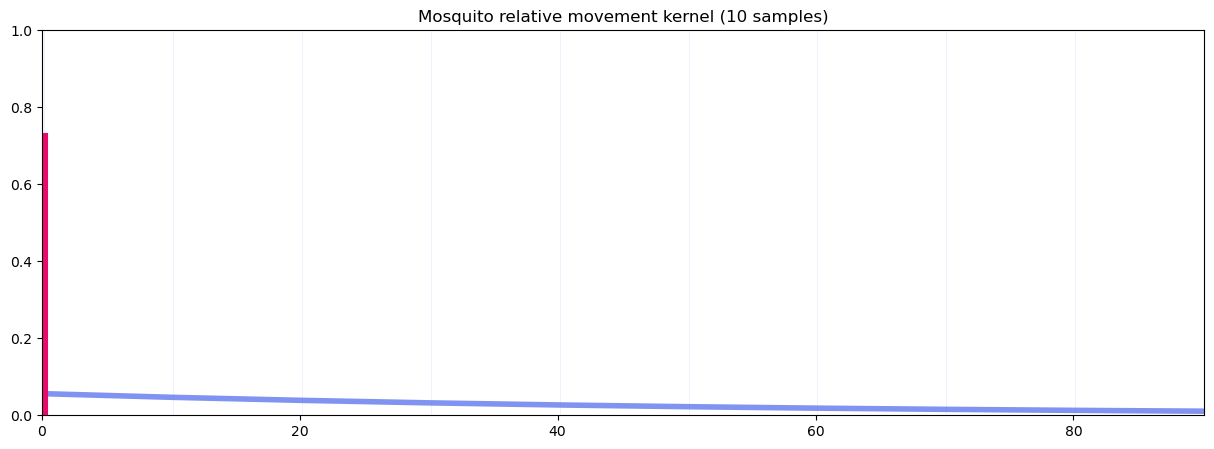

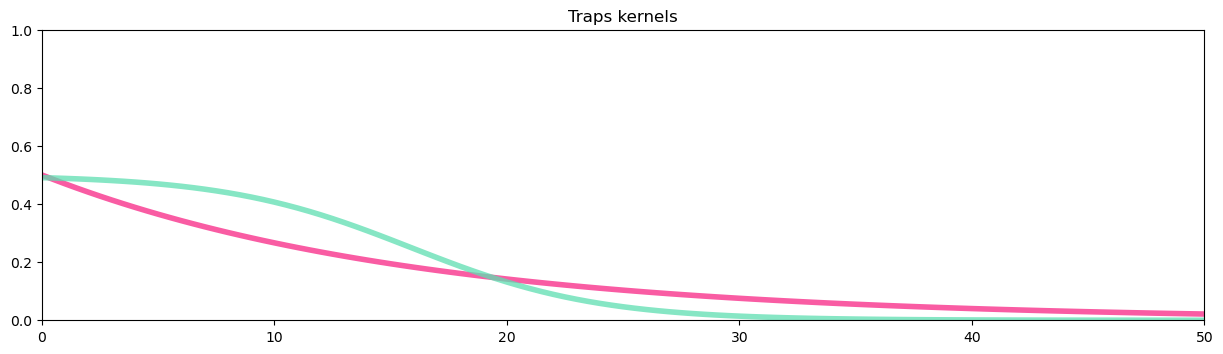

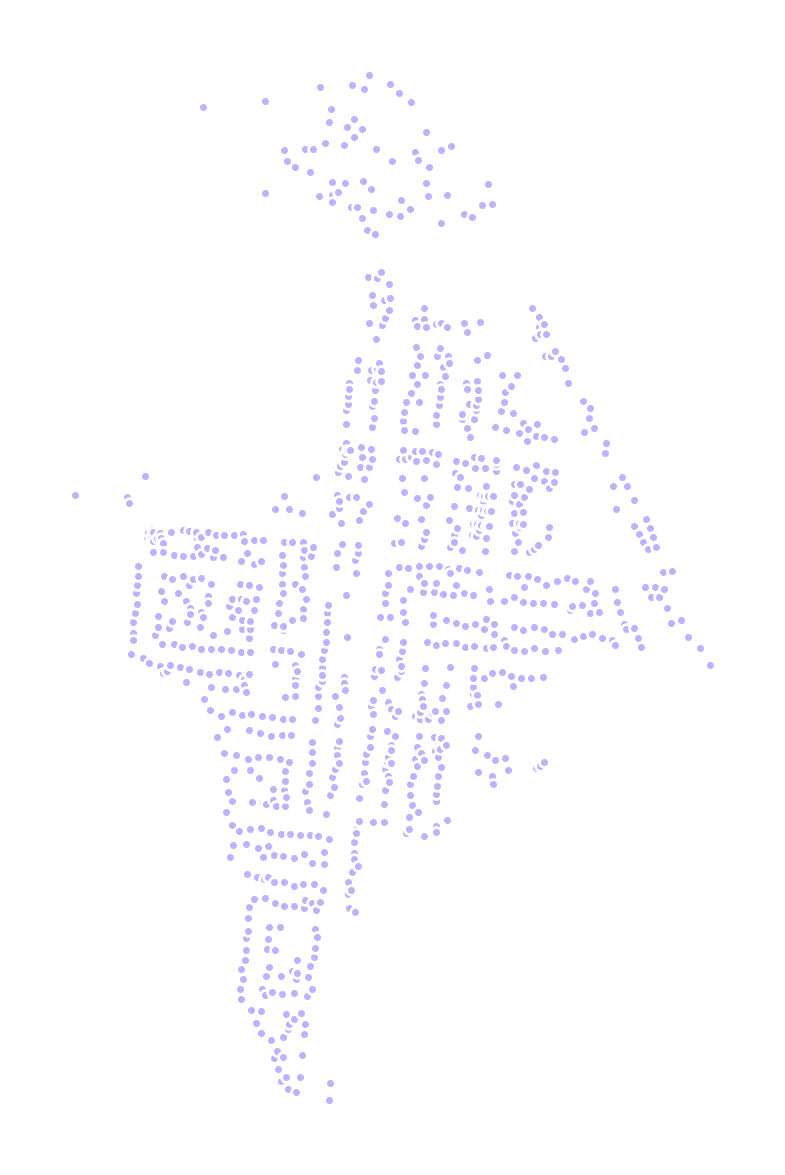

In [8]:
# Mosquito movement kernel ----------------------------------------------------
(maxRange, samples) = (100, 10)
x = np.array(list(np.arange(0.15, maxRange, maxRange/samples)))
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
(fig, ax) = srv.plotMovementKernel(fig, ax, x, lnd)
ax.set_ylim(0, 1)
ax.set_title(f'Mosquito relative movement kernel ({samples} samples)')
# Traps kernels ---------------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 15), sharey=False)
(fig, ax) = srv.plotTrapsKernels(
    fig, ax, lnd, distRange=(0, 50), aspect=.25
)
ax.set_title('Traps kernels')
# Landscape -------------------------------------------------------------------
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=50)
srv.plotClean(fig, ax, bbox=lnd.landLimits)


## Optimization

This time we will setup two different optimization alternatives: a continuous one (where traps can be placed anywhere in the landscape), and a discrete one (in which traps can only placed in existing sites).

### Discrete

The setup for our discrete optimization is pretty straightforward but we recommend the user to have a look at our São Tomé demonstration for more information on the meaning and selection of our parameters.

In [9]:
(GENS, GA_SUMSTAT, VERBOSE) = (1000, np.mean, False)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': .3, 'indpb': 0.5}, 
    {'mutpb': .4, 'indpb': 0.5},
    {'tSize': 4}
)

And let's get our optimization fired up! Please be patient as this part of the code might take around 1h for 500 generations and 16 traps!
Once it has finished, go to the **Analysis** part of this notebook.

In [10]:
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, verbose=VERBOSE, generations=GENS, pop_size=POP_SIZE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

### Continuous

In the continuous case we have some variants on the parameters. The mutation is performed by sampling a random number from a normal distribution centered around the allele's current stored coordinate, with the standard deviation needing some tweaking to scale it to the size of our landscape. In terms of the crossover, we select the crossover probability and the "blending" parameter which, when taking a value of 0.5, will do an average between the two parents and assign it to the offspring.

In [11]:
(GENS, GA_SUMSTAT, VERBOSE) = (250, np.mean, False)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': 0.5, 'alpha': 0.5}, 
    {'mean': 0, 'sd': 0.0025, 'mutpb': .4, 'ipb': .5},
    {'tSize': 3}
)
# Bounding box for traps position sampling ------------------------------------
delta=0.000015
dPad = (
    (bbox[0][0]*(1+delta), bbox[0][1]*(1-delta)), 
    (bbox[1][0]*(1-delta*20), bbox[1][1]*(1+delta*20))
)

And that's it. Let's run our GA! Please be patient as this part of the code might take around 1h for 500 generations and 16 traps!
Once it has finished, go to the **Analysis** part of this notebook.

In [12]:
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, verbose=VERBOSE,
    bbox=dPad, pop_size=POP_SIZE, generations=GENS,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

## Analysis

We're now ready to take a look at the analysis part of our pipeline. The results will vary slightly depending on if we ran the **discrete** or **continuous** GA alternative, but either way, lets have a look at the evolution of the system:

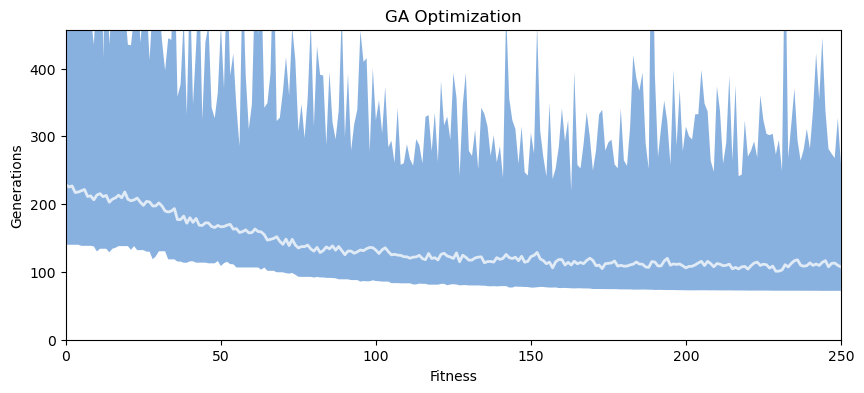

In [13]:
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
ax.set_title("GA Optimization")
ax.set_xlabel("Fitness")
ax.set_ylabel("Generations")
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5}, aspect=1
)
ax.set_aspect(.1*(GENS/max(log['avg'])*2))
ax.set_ylim(0, max(log['avg'])*2)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

And at our optimized landscape!

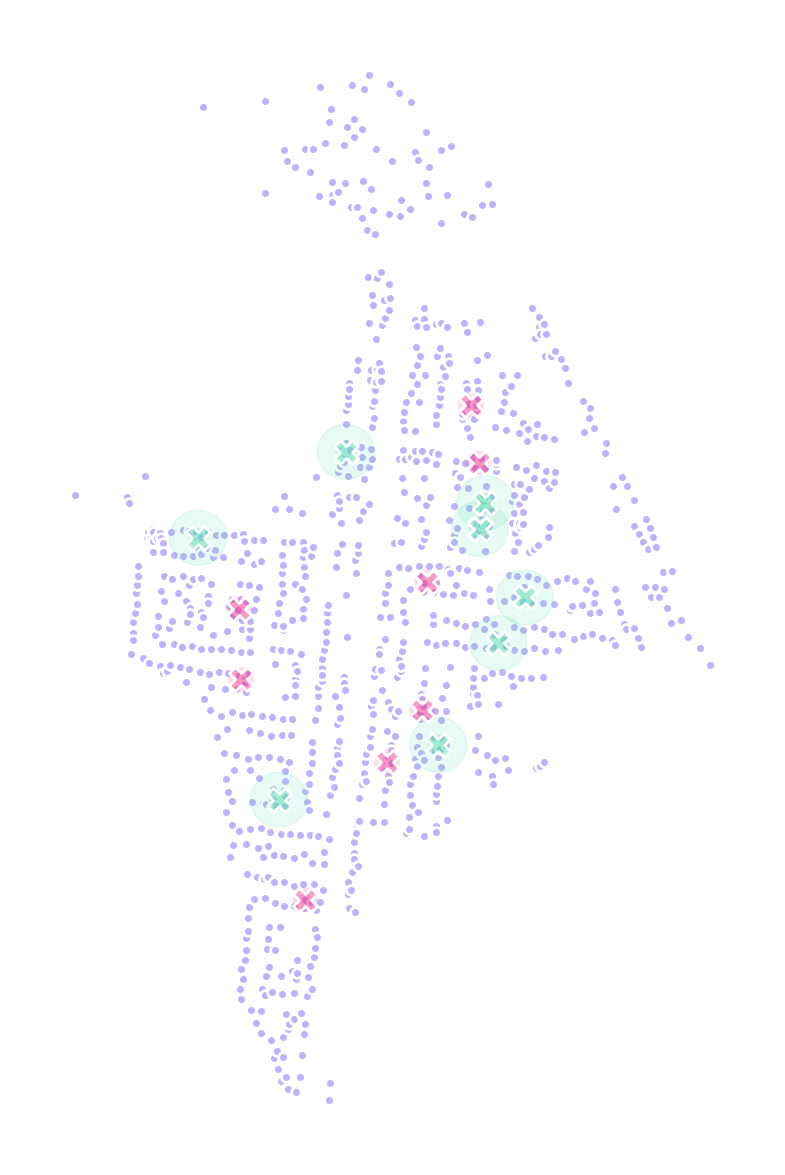

In [14]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotSites(fig, ax, size=50)
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)